In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # used for splitting training and testing data
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

torch.manual_seed(1)

In [108]:
plt.figure(figsize=(8,5))

# time steps per batch of data
seq_length = 100

time_steps = np.linspace(0, np.pi, seq_length + 1)

data = pd.read_csv('../Datasets/SectionData.csv')

x = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

<Figure size 576x360 with 0 Axes>

In [257]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, kernel_size, hidden_size, drop_prob):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential()
        
        index = 1
        in_size = input_size
        for kernel in kernel_size:
            self.model.add_module('conv' + str(index), nn.Conv1d(1, 1, kernel))
            in_size = in_size - kernel_size[-1] + 1
            index += 1

        self.model.add_module('flat', nn.Flatten())
        self.model.add_module('drop', nn.Dropout(drop_prob))
        
        index = 1
        for out_size in hidden_size:
            self.model.add_module('fc' + str(index), nn.Linear(in_size, out_size))
            in_size = out_size
            index += 1
        self.model.add_module('softmax', nn.Softmax(dim=1))
        
    def forward(self, x):
        return self.model(x)

In [258]:
BEAT_TYPES_INDEX = {
    'N': 0,
    'L': 1,
    'R': 2,
    'A': 3,
    'V': 4,
    #'F': 5,
}

def formatDataX(data):
    temp = torch.tensor(data).float()
    return temp.view(temp.size(0), 1, temp.size(1))

def formatDataY(data):
    return torch.tensor(data).float()

def preprocess(df):

    # drop ecgNum row
    df = df.drop(["ecgNum"], axis=1)
    # Classify the dependent and independent variables
    X = df.iloc[:, :-1].values
    labels = df.iloc[:, -1].values
    Y = np.array([np.insert(np.zeros(4), BEAT_TYPES_INDEX[label], 1) for label in labels])
    
    # split the data into train, validate, test
    X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.2, random_state=0)
    
    class_weights = compute_class_weight('balanced', ['N','L','R','A','V'], labels)
    
    return formatDataX(X_train), formatDataX(X_val), formatDataX(X_test), formatDataY(Y_train), formatDataY(Y_val), formatDataY(Y_test), formatDataY(class_weights)


In [259]:
#X_train, X_val, X_test, Y_train, Y_val, Y_test, weights = preprocess(data)
#print(X_train.size())
#print(X_val.size())
#print(X_test.size())
#print(Y_train.size())
#print(Y_val.size())
#print(Y_test.size())

In [272]:
# size of the input at each time step
# TODO: handle input sizes
input_size = 200
# kernel size
kernel_size = [100]#, 20]
# size of the hidden state and cell state at each time step
hidden_size = [128, 64, 5]
# dropout probability
drop_prob = 0.3

# instantiate the NN
neuralNet = NeuralNetwork(input_size, kernel_size, hidden_size, drop_prob)
print(neuralNet)

NeuralNetwork(
  (model): Sequential(
    (conv1): Conv1d(1, 1, kernel_size=(100,), stride=(1,))
    (flat): Flatten()
    (drop): Dropout(p=0.3, inplace=False)
    (fc1): Linear(in_features=101, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=5, bias=True)
    (softmax): Softmax(dim=1)
  )
)


In [273]:
# Mean Squared Error and Adam Optimizer with a learning rate of 0.01
# TODO: play with LR
#criterion = nn.MSELoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01)
#optimizer = torch.optim.Adam(neuralNet.parameters(), lr=0.01)

In [274]:
epochs = 500
print_every = 45

X_train, X_val, X_test, Y_train, Y_val, Y_test, weights = preprocess(data)

In [275]:
def test(net, X, Y, print_results=True):
    resValues, resIndices = torch.max(net(X), 1)
    testValues, testIndices = torch.max(Y, 1)
    results = np.array([np.insert(np.zeros(4), index, 1) for index in resIndices])

    conf_matrix = confusion_matrix(resIndices.numpy(), testIndices.numpy())
    
    true_pos = np.diag(conf_matrix)
    p = np.sum(conf_matrix, axis=0)
    r = np.sum(conf_matrix, axis=1)
    precision = [np.sum(true_pos[i] / p[i]) if p[i] > 0 else 0 for i in range(5)]
    recall = [np.sum(true_pos[i] / r[i]) if r[i] > 0 else 0 for i in range(5)]
    accuracy = np.sum(true_pos)/np.sum(conf_matrix)
    
    if print_results:
        print("Accuracy: {:.2%}".format(accuracy))
        print("Precision: {:.2%}".format(np.mean(precision)))
        print("Recall: {:.2%}".format(np.mean(recall)))
        print("Confusion Matrix:")
        print(conf_matrix)
    return accuracy, precision, recall

In [276]:
intermediateAccuracy = []
intermediatePrecision = []
intermediateRecall = []
intermediateEpochNum = []

# train the NN
def train(net, X, Y, num_epochs, weights):  
    criterion = nn.MSELoss()
    
    #optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    
    for epoch in range (num_epochs):
        optimizer.zero_grad()
        out = net(X)
        
#         accuracy, precision, recall = test(net, X_test, Y_test, False)
#         intermediateAccuracy.append(accuracy)
#         intermediatePrecision.append(precision)
#         intermediateRecall.append(recall)
        
        # NLLLoss
        # actValues, actIndices = torch.max(Y, 1)
        #loss = criterion(out, actIndices)
        
        # MSELoss
        loss = criterion(out, Y)
        
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 10 == 0:
            accuracy, precision, recall = test(net, X_test, Y_test, False)
            intermediateAccuracy.append(accuracy)
            intermediatePrecision.append(precision)
            intermediateRecall.append(recall)
            intermediateEpochNum.append(epoch+1)
            print("Epoch {} of {} => Loss {:.4f}  |  Accuracy {:.2%}  |  Precision {:.2%}  |  Recall {:.2%}".format(epoch+1, num_epochs, loss.item(), accuracy, np.mean(precision), np.mean(recall)))
        else:
            print("Epoch {} of {} => Loss {:.4f}\r".format(epoch+1, num_epochs, loss.item()), end="")

    return net

In [277]:
trained_NN = train(neuralNet, X_train, Y_train, epochs, weights)

Epoch 10 of 500 => Loss 0.0879  |  Accuracy 77.47%  |  Precision 29.49%  |  Recall 53.25%
Epoch 20 of 500 => Loss 0.0716  |  Accuracy 80.65%  |  Precision 41.75%  |  Recall 54.20%
Epoch 30 of 500 => Loss 0.0664  |  Accuracy 81.77%  |  Precision 41.12%  |  Recall 60.17%
Epoch 40 of 500 => Loss 0.0638  |  Accuracy 82.60%  |  Precision 44.75%  |  Recall 68.27%
Epoch 50 of 500 => Loss 0.0634  |  Accuracy 82.82%  |  Precision 43.60%  |  Recall 70.12%
Epoch 60 of 500 => Loss 0.0628  |  Accuracy 83.16%  |  Precision 44.81%  |  Recall 70.41%
Epoch 70 of 500 => Loss 0.0617  |  Accuracy 83.28%  |  Precision 45.53%  |  Recall 71.89%
Epoch 80 of 500 => Loss 0.0599  |  Accuracy 83.30%  |  Precision 45.00%  |  Recall 67.45%
Epoch 90 of 500 => Loss 0.0591  |  Accuracy 83.33%  |  Precision 44.85%  |  Recall 67.62%
Epoch 100 of 500 => Loss 0.0627  |  Accuracy 83.45%  |  Precision 45.01%  |  Recall 65.65%
Epoch 110 of 500 => Loss 0.0624  |  Accuracy 83.49%  |  Precision 45.25%  |  Recall 65.24%
Epoch 12

KeyboardInterrupt: 

In [213]:
test(trained_NN, X_train, Y_train)
test(trained_NN, X_test, Y_test)
test(trained_NN, X_val, Y_val)

Accuracy: 84.41%
Precision: 52.96%
Recall: 71.62%
Confusion Matrix:
[[47076  3372  1758   723  1472]
 [   59   979     2    65   199]
 [  184   177  2886   132   134]
 [  167   586    24   546   393]
 [  316    25     3   159  2371]]
Accuracy: 84.07%
Precision: 52.37%
Recall: 70.65%
Confusion Matrix:
[[14723  1139   512   217   492]
 [   26   274     2    25    63]
 [   66    48   901    46    50]
 [   46   179     8   173    99]
 [   96    11     3    48   694]]
Accuracy: 84.08%
Precision: 52.41%
Recall: 71.63%
Confusion Matrix:
[[11760   837   456   193   396]
 [   20   238     1    12    42]
 [   54    43   688    34    30]
 [   48   153     6   141    96]
 [   81     8     0    30   586]]


(0.8407822980003761,
 [0.9830310122878877,
  0.1860828772478499,
  0.5977410947002606,
  0.3439024390243902,
  0.5095652173913043],
 [0.8620436886087084,
  0.7603833865814696,
  0.8103651354534747,
  0.31756756756756754,
  0.8312056737588652])

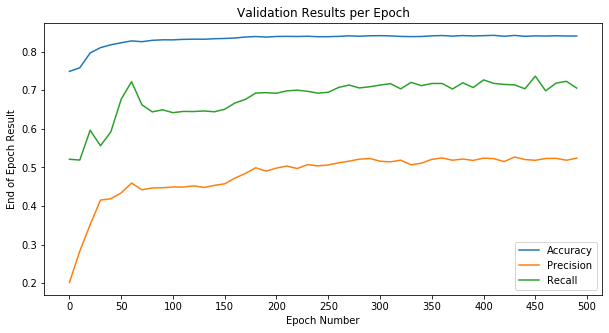

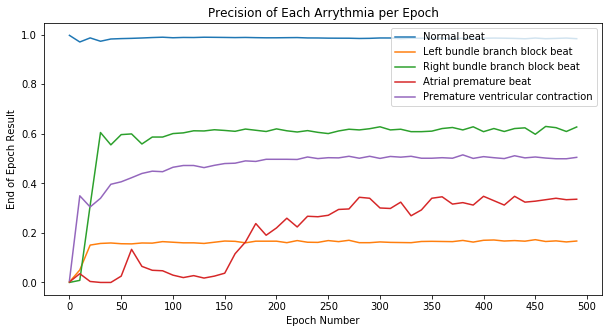

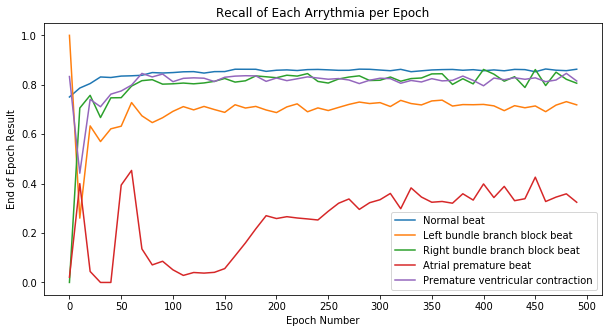

In [212]:
# intermediateAccuracy
# intermediatePrecision
# intermediateRecall
# intermediateEpochNum 
intermediateEpochNum = np.arange(0,11) * 50

import matplotlib.pyplot as plt

plt.figure(1, figsize=[10,5])
plt.plot(intermediateAccuracy)
plt.plot(np.mean(intermediatePrecision, axis=1))
plt.plot(np.mean(intermediateRecall, axis=1))
plt.xticks(np.arange(11)*5, intermediateEpochNum)
plt.legend(['Accuracy', 'Precision', 'Recall'])
plt.xlabel('Epoch Number')
plt.ylabel('End of Epoch Result')
plt.title('Validation Results per Epoch')
plt.savefig('plots/validationPerEpoch.png')
plt.show()

plt.figure(2, figsize=[10,5])
plt.plot(intermediatePrecision)
plt.xticks(np.arange(11)*5, intermediateEpochNum)
plt.legend(['Normal beat', 
            'Left bundle branch block beat', 
            'Right bundle branch block beat',
            'Atrial premature beat',
            'Premature ventricular contraction',])
plt.xlabel('Epoch Number')
plt.ylabel('End of Epoch Result')
plt.title('Precision of Each Arrythmia per Epoch')
plt.savefig('plots/precisionPerEpoch.png')
plt.show()

plt.figure(3, figsize=[10,5])
plt.plot(intermediateRecall)
plt.xticks(np.arange(11)*5, intermediateEpochNum)
plt.legend(['Normal beat', 
            'Left bundle branch block beat', 
            'Right bundle branch block beat',
            'Atrial premature beat',
            'Premature ventricular contraction',])
plt.xlabel('Epoch Number')
plt.ylabel('End of Epoch Result')
plt.title('Recall of Each Arrythmia per Epoch')
plt.savefig('plots/recallPerEpoch.png')
plt.show()

In [40]:
torch.save(trained_NN, "../Models/TestingCNN.pt")

/Users/connorsparling/opt/anaconda3/envs/HealthMonitorNN/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type NeuralNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [41]:
def evaluateNNData(data):
    x = torch.tensor(data).float()
    x = x.view(1, 1, x.size(1))
    resValues, resIndices = torch.max(trained_NN(x), 1)
    return resIndices[0]

def giveMeABad():
    testValues, testIndices = torch.max(Y_test, 1)
    for i in range(len(testIndices)):
        result = evaluateNNData(X_test[i])
        if result != 0:
            print(i)
            for x in X_test[i][0].numpy():
                print(str(x) + ",", end="")
            break

In [42]:
giveMeABad()

0
-0.04945102,-0.06852686,-0.060253512,-0.05999325,-0.061917048,-0.06135444,-0.060632315,-0.066300906,-0.07172104,-0.06755254,-0.062403575,-0.06860701,-0.069475405,-0.06408818,-0.05725357,-0.069966346,-0.079690024,-0.08211381,-0.07493032,-0.07521482,-0.08794965,-0.07493699,-0.075598195,-0.08114229,-0.08090668,-0.07671662,-0.068732545,-0.07272215,-0.078985095,-0.07977628,-0.07391122,-0.07538749,-0.07560343,-0.061540622,-0.057714816,-0.076377414,-0.07864213,-0.06763069,-0.057362847,-0.0634141,-0.06100185,-0.05355116,-0.054614406,-0.06478448,-0.063987084,-0.055587474,-0.06153449,-0.07022446,-0.069995545,-0.061547987,-0.071248434,-0.09053116,-0.08325027,-0.07753891,-0.08757886,-0.10493259,-0.1025975,-0.10117499,-0.10567484,-0.10148227,-0.09457494,-0.09174018,-0.09427118,-0.09881233,-0.091774024,-0.08282315,-0.088902995,-0.10429096,-0.10923851,-0.1030869,-0.11357075,-0.1050579,-0.10060019,-0.09241509,-0.09674091,-0.10300864,-0.09520782,-0.08896776,-0.09333152,-0.09601363,-0.08153208,-0.0869

/Users/connorsparling/opt/anaconda3/envs/HealthMonitorNN/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
